Compare synthetic spectra generated for GAMA to actual GAMA spectra

In [8]:
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM
# -- 
from redrock.external import desi

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

read in gama `SpecAll.fits` files, which contains all the references for fits file urls and such

In [66]:
fspecall = fits.open(''.join([UT.dat_dir(), 'gama/SpecAll.fits']))
fspecall.verify('fix')
specall = fspecall[1].data

 [astropy.io.fits.verify]


In [91]:
specall['cataid']

array([549638, 536565, 549654, ..., 229501, 298945, 298878], dtype=int32)

In [99]:
def getSpecURL(survey, cataid): 
    '''given survey and specid get the url of the spectra file
    '''
    isspec = (specall['survey'].lower() == survey.lower()) & (specall['cataid'] == cataid)
    if np.sum(isspec) == 0: 
        raise ValueError('no match')
    elif np.sum(isspec) > 1: 
        if specall['z'][isspec].min() == specall['z'][isspec].max(): 
            print specall['url'][isspec], specall['z'][isspec]
            return specall['url'][isspec][0]
        #raise ValueError('more than one match')
    else: 
        return specall['url'][isspec]

In [3]:
field = 'g15'
# read in GAMA-Legacy survey
cata = Cat.GamaLegacy()
gleg = cata.Read(field)
if field == 'g09': 
    nblocks = 26
elif field == 'g15': 
    nblocks = 64

In [4]:
redshift = gleg['gama-spec']['z']
ngal = len(redshift)
print('%i galaxies total' % ngal)

63004 galaxies total


In [5]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

In [6]:
i_block = 5
dir_redrock = ''.join([UT.dat_dir(), 'redrock/'])
dir_spectra = ''.join([UT.dat_dir(), 'spectra/'])

f_z_dark = ''.join([dir_redrock, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')
print('%i simulated spectra with redrock redshifts' % len(zdark_data['Z']))

1000 simulated spectra with redrock redshifts


In [9]:
f_spec_dark = ''.join([dir_spectra, 
                       'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

In [47]:
def GAMA_subsample(index, colour='C0', size=None): 
    ''' highlight the subsample in the color-magnitude and color-Halpha 
    relations of the entire GAMA sample
    '''
    if size is None: ss = 1.
    else: ss=size
    fig = plt.figure(figsize=(15, 4))
    ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, y, ylbl in zip(range(1,4), ys, ylbls):
        sub = fig.add_subplot(1,3,i)
        sub.scatter(r_absmag_gama, y, c='k', s=1.)
        sub.scatter(r_absmag_gama[index], y[index], c=colour, s=ss)
        if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
        sub.set_xlim([-14., -24])
        sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
        sub.set_ylim([-0.2, 1.6])
    fig.subplots_adjust(wspace=0.3)

    fig = plt.figure(figsize=(15, 4))
    xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
        sub = fig.add_subplot(1, len(xs), i)
        hasha = (gama_ha > 0)
        sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
        sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
        hasha = (gama_ha[index] > 0)
        sub.scatter(x[index][hasha], gama_ha[index][hasha], c=colour, s=ss)
        sub.scatter(x[index][~hasha], np.repeat(1e-2, np.sum(~hasha)), c=colour, s=ss)
        sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
        sub.set_xlim([-0.2, 2.])
        if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
        sub.set_ylim([5e-3, 2e4])
        sub.set_yscale('log')
    fig.subplots_adjust(wspace=0.3)
    return None

In [52]:
gama_spec_survey = np.array([surv.strip() for surv in gleg['gama-spec']['survey']])

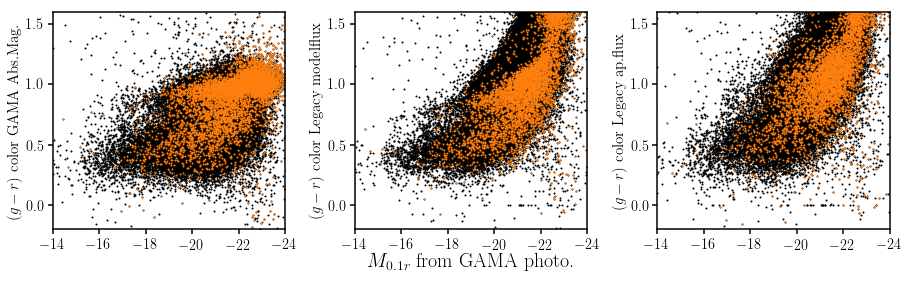

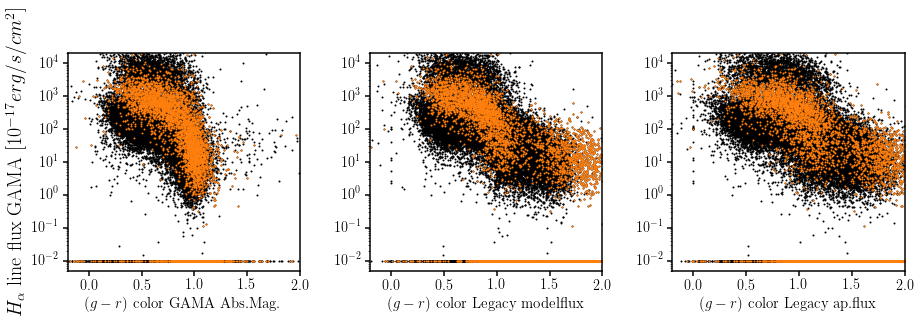

In [54]:
GAMA_subsample(np.arange(ngal)[gama_spec_survey == 'SDSS'], colour='C1')

In [60]:
is_sdss = (gama_spec_survey[i_dark] == 'SDSS') 
print('%i sdss spectra' % np.sum(is_sdss))
print gleg['gama-photo']['cataid'][i_dark[is_sdss]]

103 sdss spectra
[512740 484739 508756  47683 592462 497055 508416 545214 491514 508074
  64372 496989 485123 593481 492614 512391 878953 463453  64575 491587
 485885 508683 485652  64043 594146  48226 512475 492097 512560 485919
 508073 512169 512631 485113 485603 460396  62850 504979 568278 492355
 460399  48240  47578 492486 878905 485467 900990 492487 492478 485046
  47680  63711 594148  63816  63708 568241 485417 486215 486276  48626
 460569 508981 460756 511864 568166 491414 592179 508274 511822 457615
 567930 485156 492599 460452 492692 457445 460542 544356 509037 492430
 568414 512199 491442 567994 463373 463470 512721 511825  62236 485226
 493169 486214 593116 568530 485883  63514 567962 568401 486286 592897
  62578 491783 463493]


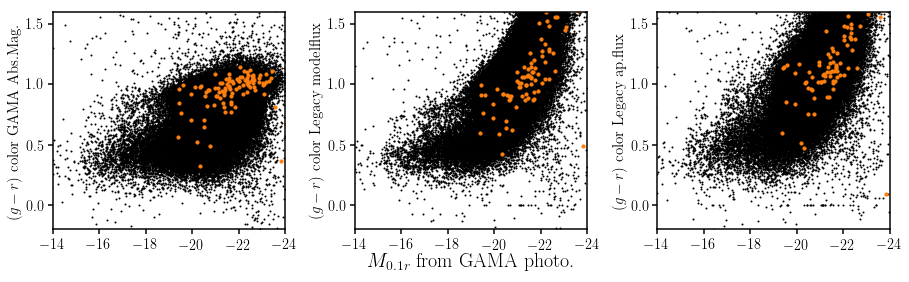

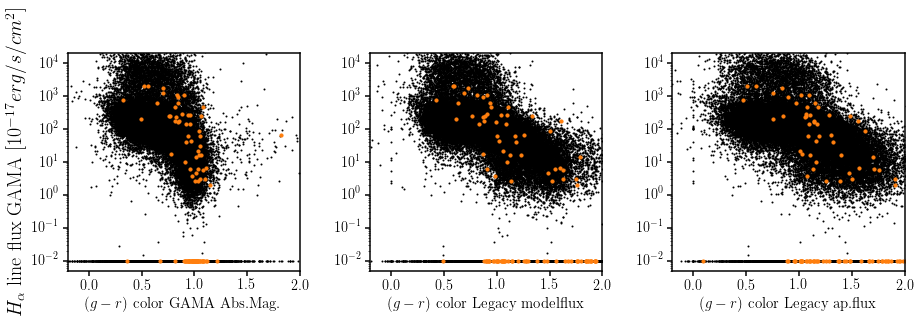

In [57]:
GAMA_subsample(i_dark[is_sdss], colour='C1', size=10)

In [64]:
is_sdss_highha = ((gama_spec_survey[i_dark] == 'SDSS') & (gama_ha[i_dark] > 10**2.5))
print('%i sdss spectra' % np.sum(is_sdss_highha))
print gleg['gama-photo']['cataid'][i_dark[is_sdss_highha]]
print gleg['gama-spec']['specid'][i_dark[is_sdss_highha]]

12 sdss spectra
[ 47683 508416 508074 485885 485919 568278 485046 486215 486276 511864
 485156 485226]
['341183707874355200               ' '1033708920843036672              '
 '1033671537447692288              ' '1034797987194234880              '
 '1033737783023265792              ' '341165016176683008               '
 '1031485707895465984              ' '1034829323275626496              '
 '1034841967659345920              ' '1033679508906993664              '
 '1031498627157092352              ' '1032566528194668544              ']


In [100]:
for ii in i_dark[is_sdss_highha]: 
    print ii, gleg['gama-spec']['cataid'][ii], gleg['gama-spec']['specid'][ii], gleg['gama-spec']['z'][ii]
    url = getSpecURL('sdss', gleg['gama-spec']['cataid'][ii])

4021 47683 341183707874355200                0.1482517
4067 508416 1033708920843036672               0.023959024
4096 508074 1033671537447692288               0.09151764
4223 485885 1034797987194234880               0.054995857
4261 485919 1033737783023265792               0.051838454
4296 568278 341165016176683008                0.082267575
4391 485046 1031485707895465984               0.047923926
4476 486215 1034829323275626496               0.13383405
4483 486276 1034841967659345920               0.057405803
4507 511864 1033679508906993664               0.055528376
['http://www.gama-survey.org/dr2/data/spectra/sdss/spSpec-52404-0918-376.fit'
 'http://www.gama-survey.org/dr2/data/spectra/sdss/spSpec-51613-0305-181.fit'] [0.05557 0.05557]
4633 485156 1031498627157092352               0.14639524
4843 485226 1032566528194668544               0.12388319


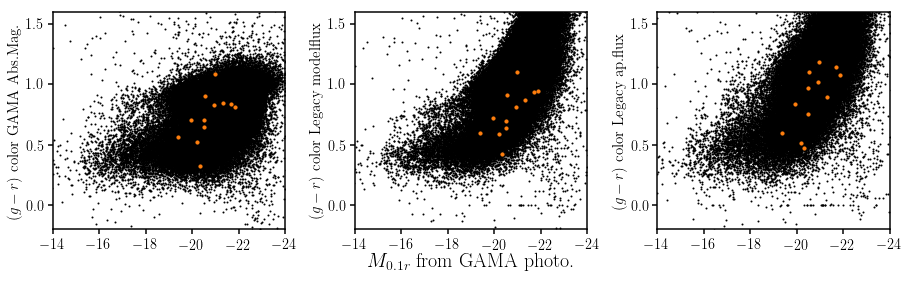

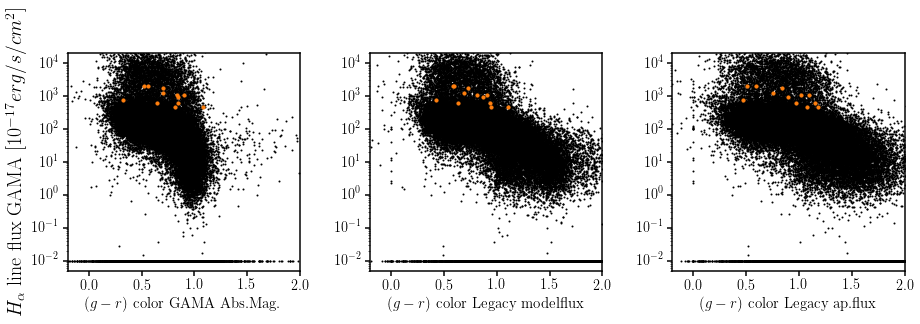

In [62]:
GAMA_subsample(i_dark[is_sdss_highha], colour='C1', size=10)

In [43]:
dir_spec = ''.join([UT.dat_dir(), 'gama/spectra/'])
f_sdss_specs = ['spec-4026-55325-0720.fit', 'spec-0916-52378-0440.fit', 'spec-0919-52409-0385.fit']

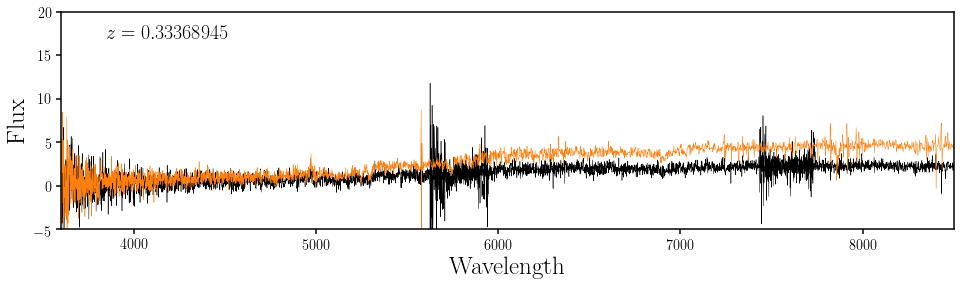

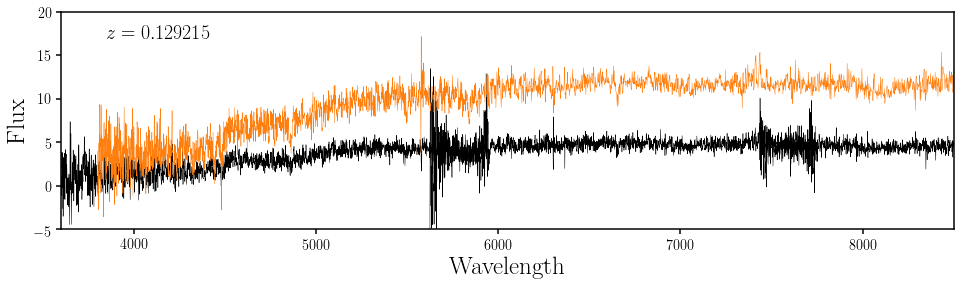

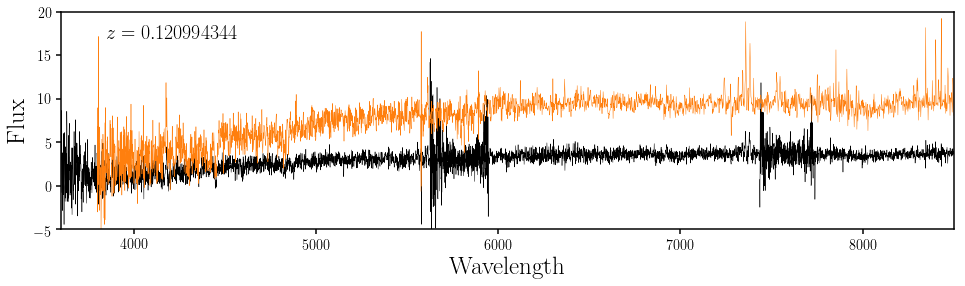

In [46]:
for i in range(3): 
    i_targ = np.arange(len(i_dark))[is_sdss][i]
    fig = plt.figure(figsize=(16,4))
    sub = fig.add_subplot(1,1,1)
    for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
        sub.plot(s_dark.wave, s_dark.flux, c='k', lw=0.5, label='Syn. Spectra') #s=0.5)
    f_sdss_spec = fits.open(''.join([dir_spec, f_sdss_specs[i]]))
    flux_sdss = f_sdss_spec[0].data[0,:]
    wave_sdss = np.logspace(f_sdss_spec[0].header['COEFF0'],
                            f_sdss_spec[0].header['COEFF0']+f_sdss_spec[0].header['COEFF1']*f_sdss_spec[0].data.shape[1],
                            f_sdss_spec[0].data.shape[1])
    sub.plot(wave_sdss, flux_sdss, c='C1', lw=0.5)

    sub.text(0.05, 0.95, '$z='+str(redshift[i_dark][i_targ])+'$',
             ha='left', va='top', transform=sub.transAxes, fontsize=20)  

    sub.set_xlabel('Wavelength', fontsize=25)
    sub.set_xlim([3600., 8500.])
    sub.set_ylabel('Flux', fontsize=25)
    sub.set_ylim([-5., 20])